In [1]:
#this notebook is to look at SST bias impact on IOD strength in the CMIP6 data that we have. 

In [2]:
#import packages
import xarray as xr
import dask
import matplotlib.pyplot as plt
import numpy as np
import os


import matplotlib as mpl
import scipy
import glob as glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import calendar
import xskillscore as xs
from scipy.stats import iqr
import functools as ft
import cartopy.crs as ccrs
import matplotlib.patches as patches
from shapely import geometry
import xskillscore as xs
from sklearn.linear_model import LinearRegression


In [3]:
def ssta(DS):
    clim = DS.groupby('time.month').mean('time')
    ssta = DS.groupby('time.month') - clim
    return ssta
def eio(DS):
    SETIO = (DS).sel(lat=slice(-10, 0),lon=slice(90, 110)).mean(['lat', 'lon'])
    return SETIO
def wtio(DS):
    wtio = (DS).sel(lat=slice(-10, 10),lon=slice(50, 70)).mean(['lat', 'lon'])
    return wtio
def arabsea(DS):
    AS = (DS).sel(lat=slice(10, 20),lon=slice(50, 70)).mean(['lat', 'lon'])
    return AS

def dmi(DS):
    WTIO = ssta(DS).sel(lat=slice(-10, 10),lon=slice(50, 70)).mean(['lat', 'lon'])
    SETIO = ssta(DS).sel(lat=slice(-10, 0),lon=slice(90, 110)).mean(['lat', 'lon'])
    return  WTIO-SETIO

In [4]:
#import dask to parallelise
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39817 instead
  warnings.warn(


In [5]:
#load in SST to compare to
OSST = xr.open_mfdataset('/g/data/e14/sm2435/CMIP6_bias_project/NOAA_OISSTv2.nc', parallel=True).sst
LSM = xr.open_dataset('/g/data/e14/sm2435/CMIP6_bias_project/LSM.nc').mask
OSST= OSST.where(LSM[0])
ODMI = dmi(OSST)
OWT = wtio(OSST)
OSE = eio(OSST)
OAS = arabsea(OSST)
OSST_clim = OSST.groupby('time.month').mean('time').sel(lat=slice(-40,30),lon=slice(30,125))
OSST_clim = OSST_clim.load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/core/indexing.py:1372: PerformanceWarning: Slicing with an out-of-order index is generating 41 times more chunks
  return self.array[key]
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/core/indexing.py:1372: PerformanceWarning: Slicing with an out-of-order index is generating 41 times more chunks
  return self.array[key]


In [6]:
CMIP_dir = '/g/data/e14/sm2435/CMIP6/CMIP6'

In [19]:
tos = 'tos/*.nc'
tos_dict={}
for model in os.listdir(CMIP_dir):
    print('start', model)
    #input file
    tos_files = (os.path.join(CMIP_dir, model, tos))
    mod={}
    try:
        sst = xr.open_mfdataset(tos_files, parallel=True)
        sst = sst.sel(time= slice('1950', '2015'))
        sst = sst.tos.sel(lat=slice(-40,30),lon=slice(30,125))
        sst = sst.load()
        #calculate DMI
        DMI = dmi(sst)
        SETIO = eio(sst).groupby('time.month')# - eio(OSST_clim)
        WTIO = wtio(sst).groupby('time.month')# - wtio(OSST_clim)
        AS = arabsea(sst)
        #calculate bias
        bias = sst.groupby('time.month').mean('time') - OSST_clim
        #pack inot dict
        mod={"bias":bias, "DMI":DMI, "SETIO":SETIO, "WTIO":WTIO, "AS":AS}
        tos_dict[model] = mod
    except Exception as e:
        print("Error. ", e)
        pass

start EC-Earth3-CC
start CAMS-CSM1-0
start ACCESS-ESM1-5
start EC-Earth3-Veg-LR
start MRI-ESM2-0
start EC-Earth3
start FGOALS-g3
start CESM2-FV2
start CanESM5
start MPI-ESM1-2-HR
start CMCC-CM2-HR4
start CESM2
start CESM2-WACCM-FV2
start MPI-ESM1-2-LR
start MPI-ESM-1-2-HAM
start EC-Earth3-AerChem
start CESM2-WACCM
start FGOALS-f3-L
start ACCESS-CM2
start EC-Earth3-Veg


In [20]:
def linear_trend(x, y):
    pf = np.polyfit(x, y, 1)
    return xr.DataArray(pf[0])

In [21]:
def regress(var1, var2):
    slope = xr.apply_ufunc(linear_trend,
                        var1, var2,
                        vectorize=True,
                        dask = 'parallelized',
                        input_core_dims=[['month'], ['month', 'lat', 'lon']],# reduce along 'model'
                        )
    return slope

In [22]:
#create model series of SSt bias
for i, model in enumerate(tos_dict.keys()):
    try:    
        dict1 = tos_dict[model]
        #load in variables
        bias = dict1["bias"]
        IOD = dict1["DMI"]
        SE = dict1['SETIO']
        WT = dict1["WTIO"]
        AS = dict1["AS"]
        IOD = IOD.groupby("time.month").std("time")
        SE = SE.groupby("time.month").mean("time")
        WT = WT.groupby("time.month").mean("time")
        AS = AS.groupby("time.month").mean("time")
         # Assigning the "model" coordinate label
        bias = bias.assign_coords(model=model)
        IOD = IOD.assign_coords(model=model)
        WT = WT.assign_coords(model=model)
        SE = SE.assign_coords(model=model)
        AS = AS.assign_coords(model=model)
        #now turn into an array
        if i == 0:
            SSTM = bias
            IODM = IOD
            WTM = WT
            SEM = SE
            ASM = AS
        else:
            SSTM = xr.concat([SSTM, bias], dim = 'model')
            IODM = xr.concat([IODM, IOD], dim = 'model')
            WTM = xr.concat([WTM, WT], dim = 'model')
            SEM = xr.concat([SEM, SE], dim = 'model')
            ASM = xr.concat([ASM, AS], dim = 'model')

    except Exception as e:
            print("something went wrong, here is the error code", e)

something went wrong, here is the error code 'DataArrayGroupBy' object has no attribute 'groupby'
something went wrong, here is the error code 'DataArrayGroupBy' object has no attribute 'groupby'
something went wrong, here is the error code 'DataArrayGroupBy' object has no attribute 'groupby'
something went wrong, here is the error code 'DataArrayGroupBy' object has no attribute 'groupby'
something went wrong, here is the error code 'DataArrayGroupBy' object has no attribute 'groupby'
something went wrong, here is the error code 'DataArrayGroupBy' object has no attribute 'groupby'
something went wrong, here is the error code 'DataArrayGroupBy' object has no attribute 'groupby'
something went wrong, here is the error code 'DataArrayGroupBy' object has no attribute 'groupby'
something went wrong, here is the error code 'DataArrayGroupBy' object has no attribute 'groupby'
something went wrong, here is the error code 'DataArrayGroupBy' object has no attribute 'groupby'
something went wrong

In [23]:
son_bias = SSTM.sel(month=slice(9,11)).mean("month")
son_IOD = IODM.sel(month=slice(9,11)).mean("month")

In [24]:
result = xr.apply_ufunc(linear_trend, son_IOD, son_bias,
                        vectorize=True,
                        dask = 'parallelized',
                        input_core_dims=[['model'], ['model']],
                        output_core_dims=[[]])


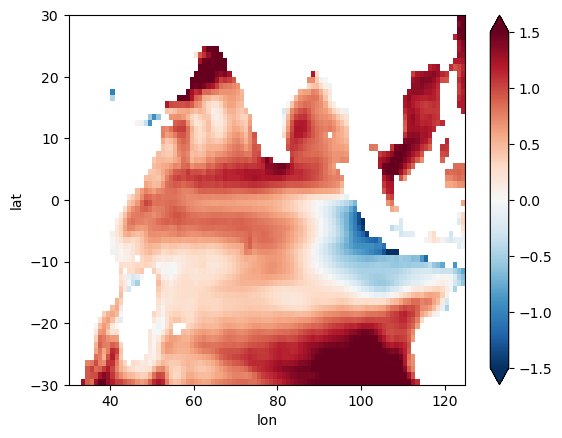

In [25]:
result.plot(vmin = -1.5, vmax = 1.5, cmap = 'RdBu_r')

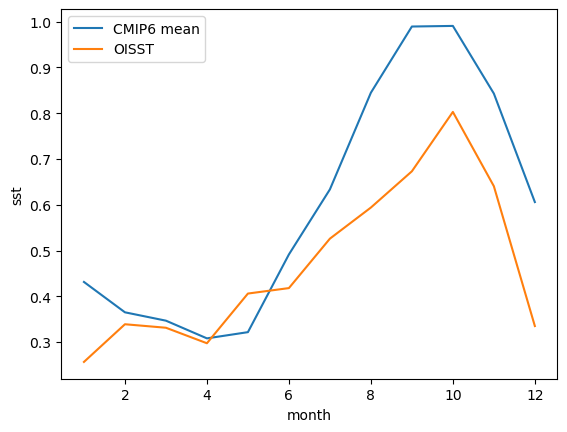

In [26]:
IODM.mean("model").plot(label = "CMIP6 mean")
ODMI.groupby('time.month').std("time").plot(label = "OISST")
plt.legend()

In [27]:
marks = ['o', '+', 'x', '*', '.']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
test ={}
count = 0
for col in colors:
    for mark in marks:
        test[count] = [mark, col]
        count = count+1

In [28]:
def plot_scatter(var1, var2, m1, m2):
    V1 = var1.sel(month =m1).mean('month')
    V2 = var2.sel(month =m2).mean('month')
    for i, mod in enumerate(var1.model):
        plt.scatter(V1.sel(model = mod),
                V2.sel(model = mod),
                    c=test[i][1], marker=test[i][0], label = str(mod.values))
    
    r = xs.pearson_r(V1,
                     V2,
                     dim = 'model')
    p = xs.pearson_r_p_value(V1,
                     V2,
                             dim = 'model')
    plt.title('Pearson r = '+f'{r.values:.2f}'+
                  ' p = '+f'{p.values:.2f}', loc='left')
    return

In [29]:
ODMI

<xarray.DataArray 'sst' (time: 483)>
dask.array<sub, shape=(483,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1981-12-01 1982-01-01 ... 2022-02-01
    month    (time) int64 12 1 2 3 4 5 6 7 8 9 10 ... 4 5 6 7 8 9 10 11 12 1 2

Text(0, 0.5, 'SON DMI standard deviation')

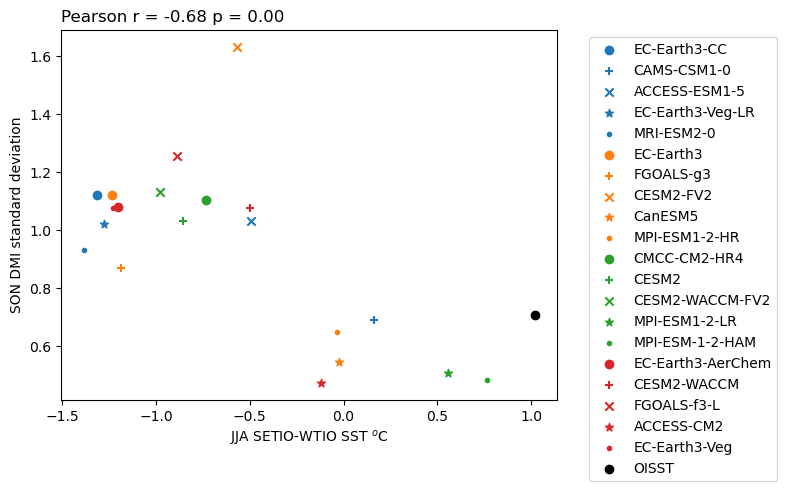

In [33]:
plot_scatter((SEM-WTM), IODM, [6,7,8], [9,10,11])
plt.scatter(((OSE-OWT).groupby('time.month').mean("time").sel(month = [6,7,8]).mean('month')),
             #(OSE-OWT).groupby('time.month').mean("time").sel(month = [6,7]).mean('month')),
            ODMI.groupby('time.month').std("time").sel(month = [9,10,11]).mean('month'), c = 'k', label = 'OISST')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')    
plt.xlabel("JJA SETIO-WTIO SST $^{o}$C")
plt.ylabel("SON DMI standard deviation")

In [87]:
#look at lead lag correlation for WTIO bias and IOD strength
#look at Lead lag correlation
from scipy.signal import correlate,correlation_lags
from scipy.stats import pearsonr

In [97]:
AW = tos_dict['EC-Earth3']['WTIO']
AI = tos_dict['EC-Earth3']['DMI']


(-12.0, 12.0)

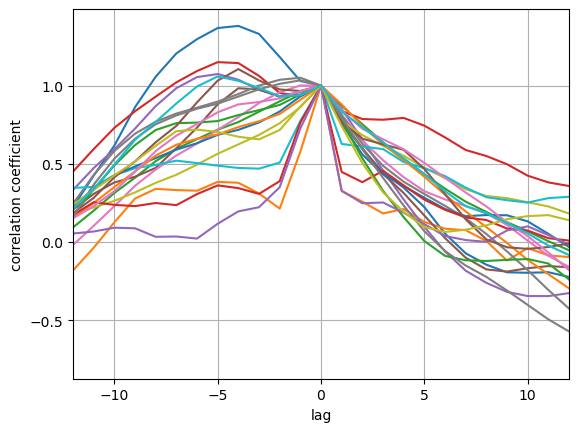

In [112]:
fig, ax = plt.subplots()
for model in tos_dict.keys():
    W = tos_dict[model]['WTIO']
    I = tos_dict[model]['DMI']
    lags = correlation_lags(W.size, I.size, mode="full")
    corr = correlate(I,W)
    corr /= corr[W.size - 1]
    lag = lags[np.argmax(corr)]
    #now plot the lines
    ax.plot(lags, corr)
    #ax.scatter(lag, max(corr))
ax.set_xlabel('lag')
ax.set_ylabel('correlation coefficient')
ax.grid(True)
ax.set_xlim(-12,12)
#ax.set_ylim(0,1.5)


In [113]:
lags = correlation_lags(OWT.size, ODMI.size, mode="full")
corr = correlate(OWT,ODMI)
corr /= corr[OWT.size - 1]
lag = lags[np.argmax(corr)]

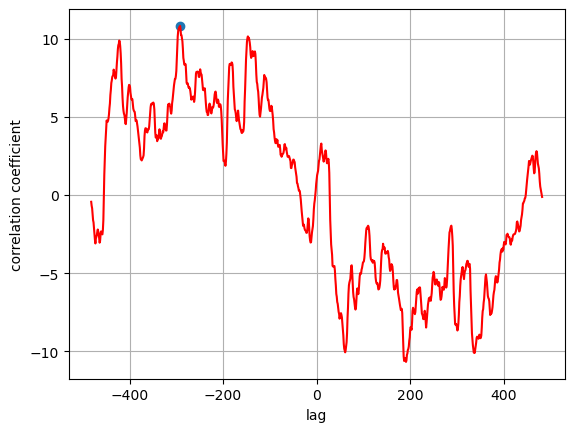

In [115]:
fig, ax = plt.subplots()
ax.plot(lags, corr, 'r')
ax.set_xlabel('lag')
ax.set_ylabel('correlation coefficient')
ax.grid(True)
#ax.set_xlim(-12,12)
ax.scatter(lag, max(corr))

Text(0.0, 1.0, 'Pearson r = -0.38 p = 0.10')

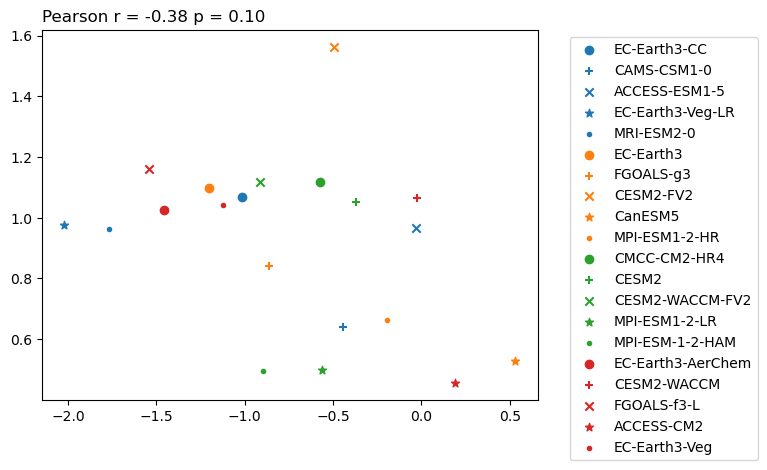

In [221]:
for i, mod in enumerate(SEM.model):
    plt.scatter(SEM.sel(month = slice(8,11)).mean('month').sel(model = mod),
            IODM.sel(month = slice(8,11)).mean('month').sel(model = mod),
                c=test[i][1], marker=test[i][0], label = str(mod.values))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
r = xs.pearson_r(SEM.sel(month = slice(8,11)).mean('month'),
                 IODM.sel(month = slice(8,11)).mean('month'),
                 dim = 'model')
p = xs.pearson_r_p_value(SEM.sel(month = slice(8,11)).mean('month'),
                 IODM.sel(month = slice(8,11)).mean('month'),
                         dim = 'model')
plt.title('Pearson r = '+f'{r.values:.2f}'+
              ' p = '+f'{p.values:.2f}', loc='left')

In [165]:
from scipy.stats import pearsonr

In [160]:
def corrcoef_func(x, y):
    x, y = np.nan_to_num(x), np.nan_to_num(y)
    r,p =  pearsonr(x, y)
    return r,p

In [167]:
def convert_to_da(arr):
    arr_xr = xr.DataArray(arr, 
                    coords={'lat': son_bias.lat, 'lon': son_bias.lon}, 
                    dims=["lat", "lon"])
    return arr_xr

In [168]:
def calc_pearsonr(arr, index):
    corr_coef, pvals = np.apply_along_axis(corrcoef_func, axis=0, arr=arr, y=index)
    corr_coef = convert_to_da(corr_coef)
    pvals = convert_to_da(pvals)
    return corr_coef, pvals

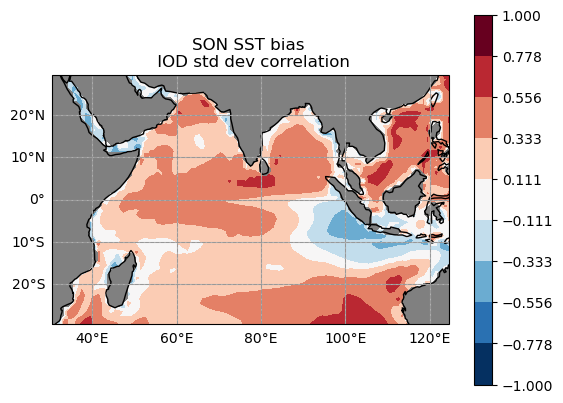

In [172]:
r,p = calc_pearsonr(son_bias, son_IOD)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

r.plot.contourf(ax=ax, transform=ccrs.PlateCarree(),
                        vmin = -1, vmax = 1, levels = 10,  cmap = "RdBu_r")
ax.set_title('SON SST bias \n IOD std dev correlation')
ax.coastlines(color = 'k')
ax.gridlines()
ax.set_facecolor('grey')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

In [178]:
sigp = xr.where(p<0.1,1,0)

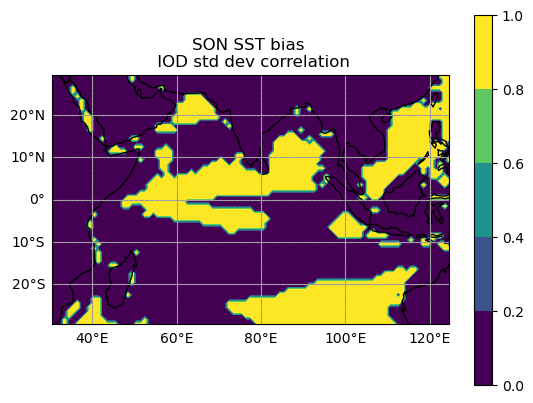

In [180]:
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

sigp.plot.contourf(ax=ax, transform=ccrs.PlateCarree())
ax.set_title('SON SST bias \n IOD std dev correlation')
ax.coastlines(color = 'k')
ax.gridlines()
ax.set_facecolor('grey')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False